In [1]:
'''Modified from sklearn documentation: https://scikit-learn.org/stable/modules/compose.html
'''
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sklearn.datasets
from sklearn.linear_model import LogisticRegression, Ridge
# from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score,r2_score
from sklearn.model_selection import train_test_split
import sklearn.utils


from pcsp import PCSPipeline, ModuleSet, Module, init_args # must install pcsp first (pip install pcsp)
from pcsp.pipeline import build_graph

from functools import partial
import itertools
import networkx as nx
np.set_printoptions(threshold=5) # to limit printing

# basic pipeline

{'X_train': array([[-0.30582021, -0.97541273, -1.15871714, -1.35132194, -0.54657674],
       [-1.22242099,  0.8517753 , -0.80402087, -0.01690056,  0.2283352 ],
       [-1.61601535,  0.49442318, -1.57177933, -0.73822631, -0.51644285],
       ...,
       [ 0.33619823,  0.50332566,  0.81539492,  0.84065391,  0.75470501],
       [-0.05369964,  0.56461721,  0.38944096,  0.59680371,  0.1549036 ],
       [ 1.26121505, -0.97449632,  0.75244047, -0.09102092,  0.50116769]]), '__prev__': 'init'}
('X_train', 'subsampling_0', 'LR', 'X_test', 'Acc')
('X_train', 'subsampling_0', 'LR', 'X_test', 'Bal_Acc')
('X_train', 'subsampling_0', 'DT', 'X_test', 'Acc')
('X_train', 'subsampling_0', 'DT', 'X_test', 'Bal_Acc')
('X_train', 'subsampling_1', 'LR', 'X_test', 'Acc')
('X_train', 'subsampling_1', 'LR', 'X_test', 'Bal_Acc')
('X_train', 'subsampling_1', 'DT', 'X_test', 'Acc')
('X_train', 'subsampling_1', 'DT', 'X_test', 'Bal_Acc')
('X_train', 'subsampling_2', 'LR', 'X_test', 'Acc')
('X_train', 'subsampling_2

/home/james/school/yugroup/projects/pcs_inference/pcs_pipeline/pcs-pipeline/pcsp/pipeline.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


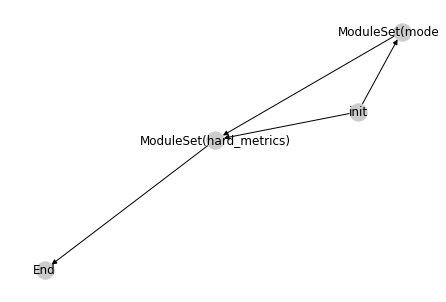

In [2]:
# initialize data
np.random.seed(13)
X, y = sklearn.datasets.make_classification(n_samples=50, n_features=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) # ex. with another split?
X_train, X_test, y_train, y_test = init_args((X_train, X_test, y_train, y_test), # could run this line higher (on X, y)
                                              names=['X_train', 'X_test', 'X_train', 'X_test'])  # optionally provide names for each of these

print(X_train)


# subsample data
subsampling_funcs = [partial(sklearn.utils.resample,
                            n_samples=20,
                            random_state=i)
                     for i in range(3)]
subsampling_set = ModuleSet(name='subsampling',
                            modules=subsampling_funcs)
# print('X_train', X_train, 'y_train', y_train)
X_trains, y_trains = subsampling_set(X_train, y_train) # subsampling_set([X_train, X_train], [y_train, y_train]) # artificially make it seem like there are multiple dsets (data_0 and data_1)


# fit models
modeling_set = ModuleSet(name='modeling',
                         modules=[LogisticRegression(max_iter=1000, tol=0.1),
                                  DecisionTreeClassifier()],
                         module_keys=["LR", "DT"], out={})

modeling_set.fit(X_trains, y_trains)
preds_test = modeling_set.predict(X_test)

# get metrics
hard_metrics_set = ModuleSet(name='hard_metrics',
                             modules=[accuracy_score, balanced_accuracy_score],
                             module_keys=["Acc", "Bal_Acc"], out={})

hard_metrics = hard_metrics_set.evaluate(y_test, preds_test)
#hard_metrics.__prev__[0]
#inspect the pipeline
for k1, v1 in hard_metrics.items():
    print(k1)
G = build_graph(hard_metrics, draw=True)
plt.show()

# feature engineering pipeline
**this data set predicts boston house-preices dataset (regression)**

In [3]:
# get data as df
np.random.seed(13)
data = sklearn.datasets.load_boston()
df = pd.DataFrame.from_dict(data['data'])
df.columns = data['feature_names']
y = data['target']
X_train, X_test, y_train, y_test = init_args(train_test_split(df, y, random_state=42),
                                             names=['X_train', 'X_test', 'X_train', 'X_test'])


# feature extraction - extracts two different sets of features from the same data
def extract_feats(df: pd.DataFrame, feat_names=['CRIM', 'ZN', 'INDUS', 'CHAS']):
    '''extract specific columns from dataframe
    '''
    return df[feat_names]
feat_extraction_funcs = [partial(extract_feats, feat_names=['CRIM', 'ZN', 'INDUS', 'CHAS']),
                         partial(extract_feats, feat_names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE']),
                        ]
feat_extraction = ModuleSet(name='feat_extraction',
                            modules=feat_extraction_funcs)

X_feats_train = feat_extraction(X_train)
X_feats_test = feat_extraction(X_test)

#print(X_feats_train) 
#X_feats_train(),still weird that this is a list
#X_feats_train
# TODO: this is broken atm.. may want to preserve ModuleSet.modules in their original form of modules / functions
X_feats_test = feat_extraction(X_test) # still weird that this is a list


#fit models
y = {
     'data_0': y_train,
     'data_1': y_test
}

y_train_dict = {('X_train', 'feat_extraction_0'): y_train, ('X_train', 'feat_extraction_1'): y_train}
modeling_set = ModuleSet(name='modeling',
                         modules=[Ridge(max_iter=1000, tol=0.1),
                                  DecisionTreeRegressor()],
                         module_keys=["Ridge", "DT"])

# how can we properly pass a y here so that it will fit properly?
# this runs, but modeling_set.out is empty
_ = modeling_set.fit(X_feats_train, y_train_dict)

#get predictions
preds_all = modeling_set.predict(X_feats_test)

y_test_dict = {('data_0', 'feat_extraction_0'): y_test, ('data_0', 'feat_extraction_1'): y_test}

#get metrics
hard_metrics_set = ModuleSet(name='hard_metrics',
                             modules=[r2_score],
                            module_keys=["r2"])
hard_metrics = hard_metrics_set.evaluate(y_test_dict, preds_all)


# inspect the pipeline
#for k in hard_metrics:
#     print(k, hard_metrics[k])
#G = build_graph(hard_metrics, draw=True)
#plt.show()
hard_metrics

{'__prev__': <pcsp.module_set.ModuleSet at 0x7f16cbe3adf0>}

In [4]:
X_feats_train

{('X_train',
  'feat_extraction_0'):          CRIM    ZN  INDUS  CHAS
 182   0.09103   0.0   2.46   0.0
 155   3.53501   0.0  19.58   1.0
 280   0.03578  20.0   3.33   0.0
 126   0.38735   0.0  25.65   0.0
 329   0.06724   0.0   3.24   0.0
 ..        ...   ...    ...   ...
 106   0.17120   0.0   8.56   0.0
 270   0.29916  20.0   6.96   0.0
 348   0.01501  80.0   2.01   0.0
 435  11.16040   0.0  18.10   0.0
 102   0.22876   0.0   8.56   0.0
 
 [379 rows x 4 columns],
 ('X_train',
  'feat_extraction_1'):          CRIM    ZN  INDUS  CHAS     NOX     RM   AGE
 182   0.09103   0.0   2.46   0.0  0.4880  7.155  92.2
 155   3.53501   0.0  19.58   1.0  0.8710  6.152  82.6
 280   0.03578  20.0   3.33   0.0  0.4429  7.820  64.5
 126   0.38735   0.0  25.65   0.0  0.5810  5.613  95.6
 329   0.06724   0.0   3.24   0.0  0.4600  6.333  17.2
 ..        ...   ...    ...   ...     ...    ...   ...
 106   0.17120   0.0   8.56   0.0  0.5200  5.836  91.9
 270   0.29916  20.0   6.96   0.0  0.4640  5.856  42.

In [5]:
modeling_set.modules

{'Ridge': Ridge(max_iter=1000, tol=0.1), 'DT': DecisionTreeRegressor()}

In [6]:
y_train_dict

{('X_train',
  'feat_extraction_0'): {'X_train': array([37.9, 15.6, 45.4, ..., 24.5, 13.4, 18.6]), '__prev__': 'init'},
 ('X_train',
  'feat_extraction_1'): {'X_train': array([37.9, 15.6, 45.4, ..., 24.5, 13.4, 18.6]), '__prev__': 'init'}}

In [7]:
preds_all

{'__prev__': <pcsp.module_set.ModuleSet at 0x7f16cbe3ad90>}

# tracking things w Pipeline (deprecated)

In [8]:
p = PCSPipeline()

In [9]:
p.steps = [subsampling_set, modeling_set, hard_metrics_set] # how to deal w/ hard metrics?

In [10]:
# broken
# p.run(X_train, y_train)

In [11]:
p.steps[2].modules

{'r2': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>}

In [12]:
# broken
#df = p.generate_names()
#df['hard_metrics'] = hard_metrics
#df